<a href="https://colab.research.google.com/github/Jueunkim429/DeepLearning/blob/main/Transfer_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 숙명여자대학교 기계시스템학부 딥러닝 2023 (강사: 심주용)
# *Lab 5 Transfer Learning*

In this tutorial, you will learn how to train a convolutional neural network for
image classification using transfer learning. You can read more about the transfer
learning at [cs231n notes](https://cs231n.github.io/transfer-learning/)_

**Source**: [Pytorch Tutorial](https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html)

Quoting these notes,

    In practice, very few people train an entire Convolutional Network
    from scratch (with random initialization), because it is relatively
    rare to have a dataset of sufficient size. Instead, it is common to
    pretrain a ConvNet on a very large dataset (e.g. ImageNet, which
    contains 1.2 million images with 1000 categories), and then use the
    ConvNet either as an initialization or a fixed feature extractor for
    the task of interest.

These two major transfer learning scenarios look as follows:

-  **Finetuning the ConvNet**: Instead of random initialization, we
   initialize the network with a pretrained network, like the one that is
   trained on imagenet 1000 dataset. Rest of the training looks as
   usual.
-  **ConvNet as fixed feature extractor**: Here, we will freeze the weights
   for all of the network except that of the final fully connected
   layer. This last fully connected layer is replaced with a new one
   with random weights and only this layer is trained.

   



In [1]:
# License: BSD
# Author: Sasank Chilamkurthy

# For tips on running notebooks in Google Colab, see
# https://pytorch.org/tutorials/beginner/colab
%matplotlib inline

from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

cudnn.benchmark = True
plt.ion()   # interactive mode

## Load Data

We will use torchvision and torch.utils.data packages for loading the
data.

The problem we're going to solve today is to train a model to classify
**ants** and **bees**. We have about 120 training images each for ants and bees.
There are 75 validation images for each class. Usually, this is a very
small dataset to generalize upon, if trained from scratch. Since we
are using transfer learning, we should be able to generalize reasonably
well.

We are going to use [datasets.ImageFolder](https://pytorch.org/vision/main/datasets.html#base-classes-for-custom-datasets).


This dataset is a very small subset of imagenet.

.. Note ::
   Download the data from
   [here](https://download.pytorch.org/tutorial/hymenoptera_data.zip)
   and extract it to the current directory.



In [2]:
!wget https://download.pytorch.org/tutorial/hymenoptera_data.zip

--2023-06-05 08:35:42--  https://download.pytorch.org/tutorial/hymenoptera_data.zip
Resolving download.pytorch.org (download.pytorch.org)... 13.224.249.92, 13.224.249.33, 13.224.249.111, ...
Connecting to download.pytorch.org (download.pytorch.org)|13.224.249.92|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 47286322 (45M) [application/zip]
Saving to: ‘hymenoptera_data.zip’

hymenoptera_data.zi 100%[===================>]  45.10M  23.5MB/s    in 1.9s    

2023-06-05 08:35:44 (23.5 MB/s) - ‘hymenoptera_data.zip’ saved [47286322/47286322]



In [3]:
!unzip hymenoptera_data.zip

Archive:  hymenoptera_data.zip
   creating: hymenoptera_data/
   creating: hymenoptera_data/train/
   creating: hymenoptera_data/train/ants/
  inflating: hymenoptera_data/train/ants/0013035.jpg  
  inflating: hymenoptera_data/train/ants/1030023514_aad5c608f9.jpg  
  inflating: hymenoptera_data/train/ants/1095476100_3906d8afde.jpg  
  inflating: hymenoptera_data/train/ants/1099452230_d1949d3250.jpg  
  inflating: hymenoptera_data/train/ants/116570827_e9c126745d.jpg  
  inflating: hymenoptera_data/train/ants/1225872729_6f0856588f.jpg  
  inflating: hymenoptera_data/train/ants/1262877379_64fcada201.jpg  
  inflating: hymenoptera_data/train/ants/1269756697_0bce92cdab.jpg  
  inflating: hymenoptera_data/train/ants/1286984635_5119e80de1.jpg  
  inflating: hymenoptera_data/train/ants/132478121_2a430adea2.jpg  
  inflating: hymenoptera_data/train/ants/1360291657_dc248c5eea.jpg  
  inflating: hymenoptera_data/train/ants/1368913450_e146e2fb6d.jpg  
  inflating: hymenoptera_data/train/ants/147318

In [4]:
# Data augmentation and normalization for training
# Just normalization for validation
train_data_transforms = transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

valid_data_transforms = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

data_dir = 'hymenoptera_data'

train_image_datasets = datasets.ImageFolder(os.path.join(data_dir, 'train'),
                                          train_data_transforms)
valid_image_datasets = datasets.ImageFolder(os.path.join(data_dir, 'val'),
                                          valid_data_transforms)

train_dataloaders = torch.utils.data.DataLoader(train_image_datasets, batch_size=4,
                                             shuffle=True, num_workers=4)
valid_dataloaders = torch.utils.data.DataLoader(valid_image_datasets, batch_size=4,
                                             shuffle=True, num_workers=4)

dataset_sizes = {'train': len(train_image_datasets),
                 'val': len(valid_image_datasets)}

class_names = train_image_datasets.classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


## 과제1 Train과 Validation 데이터의 갯수와 이미지의 크기는 어떻게 다른가? 각 dataloaders에서 추출한 데이터의 shape은 무엇인가?

In [5]:
# 데이터의 shape 추출
train_batch = next(iter(train_dataloaders))
valid_batch = next(iter(valid_dataloaders))

train_data_shape = train_batch[0].shape
valid_data_shape = valid_batch[0].shape

print("Train Dataset Size:", dataset_sizes['train'])
print("Validation Dataset Size:", dataset_sizes['val'])
print("Train Data Shape:", train_data_shape)
print("Validation Data Shape:", valid_data_shape)

Train Dataset Size: 244
Validation Dataset Size: 153
Train Data Shape: torch.Size([4, 3, 224, 224])
Validation Data Shape: torch.Size([4, 3, 224, 224])


## 과제2 : train_data_transforms과 valid_data_transforms이 어떻게 다른지 시각화 하세요.

In [6]:
image_datasets= datasets.ImageFolder(os.path.join(data_dir,'train'))
img, label = next(iter(image_datasets))
np.array(img).shape, label, np.array(img)

((512, 768, 3),
 0,
 array([[[ 80, 151, 233],
         [ 80, 151, 233],
         [ 80, 151, 233],
         ...,
         [ 81, 152, 234],
         [ 79, 150, 232],
         [ 76, 147, 229]],
 
        [[ 81, 152, 234],
         [ 81, 152, 234],
         [ 81, 152, 234],
         ...,
         [ 81, 152, 234],
         [ 79, 150, 232],
         [ 76, 147, 229]],
 
        [[ 82, 153, 235],
         [ 82, 153, 235],
         [ 82, 153, 235],
         ...,
         [ 80, 151, 233],
         [ 79, 150, 232],
         [ 77, 148, 230]],
 
        ...,
 
        [[ 87, 160, 237],
         [ 87, 160, 237],
         [ 86, 159, 236],
         ...,
         [ 44,  92, 141],
         [ 95, 158, 235],
         [ 90, 157, 228]],
 
        [[ 87, 160, 237],
         [ 87, 160, 237],
         [ 86, 159, 236],
         ...,
         [ 84, 147, 226],
         [ 90, 160, 255],
         [ 84, 152, 233]],
 
        [[ 87, 160, 237],
         [ 87, 160, 237],
         [ 86, 159, 236],
         ...,
        

In [7]:
np.array(img)

array([[[ 80, 151, 233],
        [ 80, 151, 233],
        [ 80, 151, 233],
        ...,
        [ 81, 152, 234],
        [ 79, 150, 232],
        [ 76, 147, 229]],

       [[ 81, 152, 234],
        [ 81, 152, 234],
        [ 81, 152, 234],
        ...,
        [ 81, 152, 234],
        [ 79, 150, 232],
        [ 76, 147, 229]],

       [[ 82, 153, 235],
        [ 82, 153, 235],
        [ 82, 153, 235],
        ...,
        [ 80, 151, 233],
        [ 79, 150, 232],
        [ 77, 148, 230]],

       ...,

       [[ 87, 160, 237],
        [ 87, 160, 237],
        [ 86, 159, 236],
        ...,
        [ 44,  92, 141],
        [ 95, 158, 235],
        [ 90, 157, 228]],

       [[ 87, 160, 237],
        [ 87, 160, 237],
        [ 86, 159, 236],
        ...,
        [ 84, 147, 226],
        [ 90, 160, 255],
        [ 84, 152, 233]],

       [[ 87, 160, 237],
        [ 87, 160, 237],
        [ 86, 159, 236],
        ...,
        [ 79, 160, 242],
        [ 78, 159, 250],
        [ 84, 161, 233]]

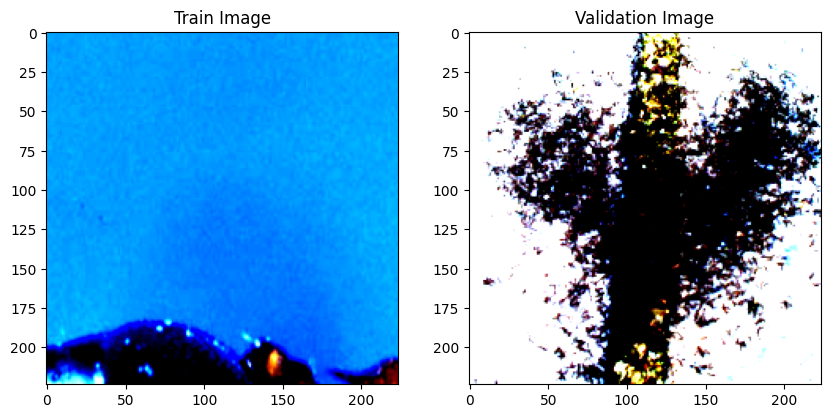

In [8]:
# 첫 번째 이미지를 가져와서 변환 적용 후 시각화
train_image = train_image_datasets[0][0]
valid_image = valid_image_datasets[0][0]

fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(train_image.permute(1, 2, 0))
axes[0].set_title('Train Image')
axes[1].imshow(valid_image.permute(1, 2, 0))
axes[1].set_title('Validation Image')

plt.show()

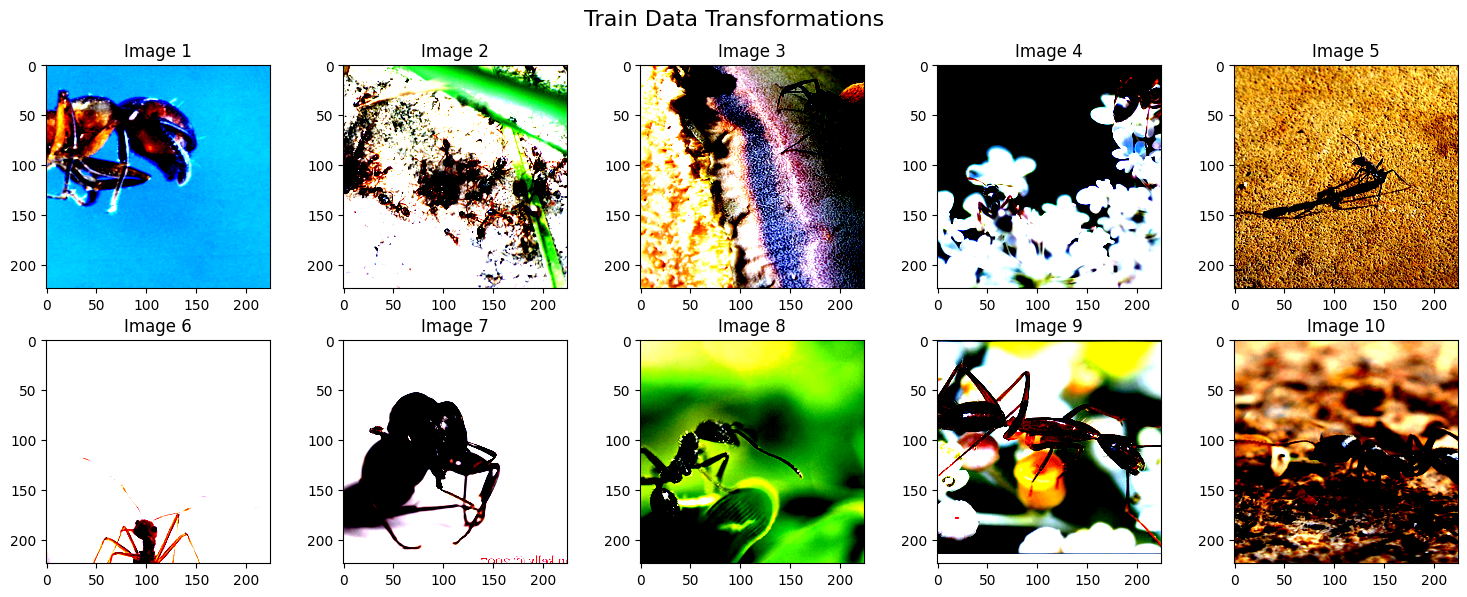

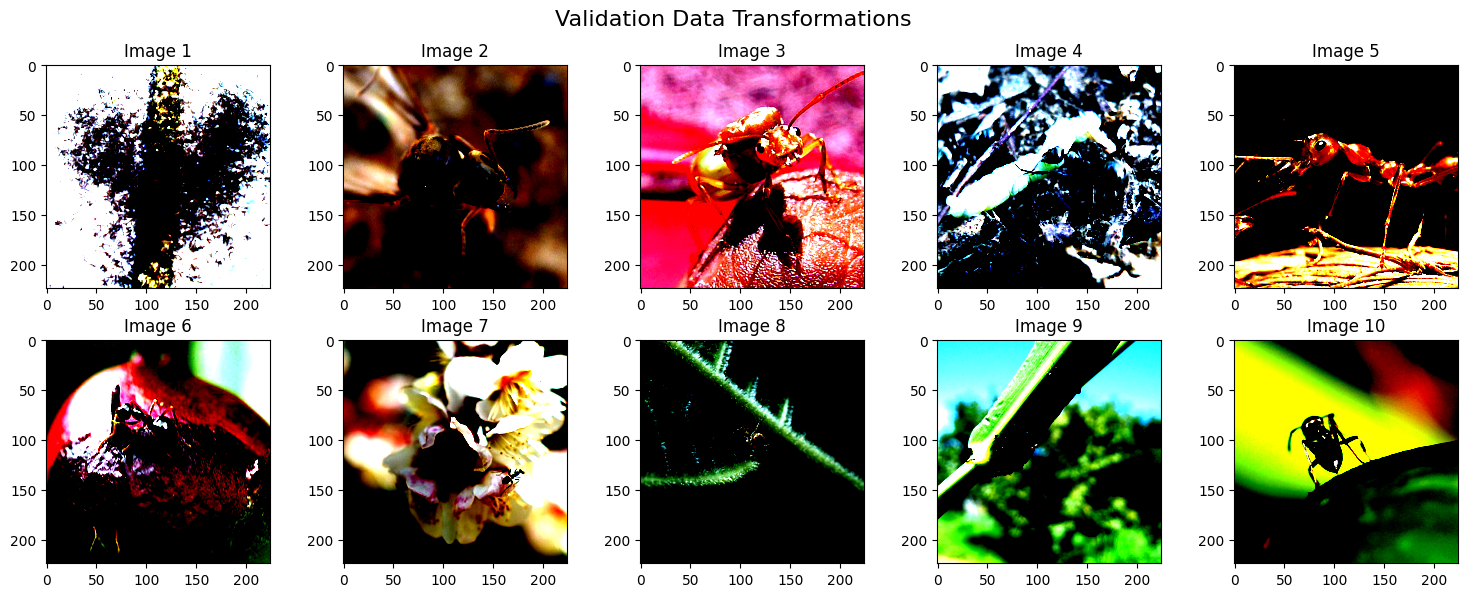

In [9]:
# 학습 데이터 시각화
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
fig.suptitle('Train Data Transformations', fontsize=16)

for i in range(5):
    image, _ = train_image_datasets[i]
    axes[0, i].imshow(image.permute(1, 2, 0))
    axes[0, i].set_title(f'Image {i+1}')

for i in range(5, 10):
    image, _ = train_image_datasets[i]
    axes[1, i-5].imshow(image.permute(1, 2, 0))
    axes[1, i-5].set_title(f'Image {i+1}')

plt.tight_layout()
plt.show()

# 검증 데이터 시각화
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
fig.suptitle('Validation Data Transformations', fontsize=16)

for i in range(5):
    image, _ = valid_image_datasets[i]
    axes[0, i].imshow(image.permute(1, 2, 0))
    axes[0, i].set_title(f'Image {i+1}')

for i in range(5, 10):
    image, _ = valid_image_datasets[i]
    axes[1, i-5].imshow(image.permute(1, 2, 0))
    axes[1, i-5].set_title(f'Image {i+1}')

plt.tight_layout()
plt.show()

## 과제3: datasets.ImageFolder 대신 Dataset Class를 작성하세요.

In [10]:
import torch
import os
from torchvision import transforms
from torch.utils.data import Dataset
from PIL import Image

class Dataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.data_dir = data_dir
        self.transform = transform
        self.images, self.labels = self.load_dataset()

    def load_dataset(self):
        images = []
        labels = []
        classes = os.listdir(self.data_dir)
        for idx, class_name in enumerate(classes):
            class_dir = os.path.join(self.data_dir, class_name)
            if os.path.isdir(class_dir):
                image_files = os.listdir(class_dir)
                for image_file in image_files:
                    image_path = os.path.join(class_dir, image_file)
                    images.append(image_path)
                    labels.append(idx)

        return images, labels

    def __getitem__(self, index):
        image_path = self.images[index]
        label = self.labels[index]

        image = Image.open(image_path).convert("RGB")

        if self.transform is not None:
            image = self.transform(image)

        return image, label

    def __len__(self):
        return len(self.images)

# 데이터 변환 함수 정의
train_data_transforms = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

valid_data_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

data_dir = 'hymenoptera_data'

# 학습 데이터셋 및 검증 데이터셋 생성
train_dataset = Dataset(os.path.join(data_dir, 'train'), transform=train_data_transforms)
valid_dataset = Dataset(os.path.join(data_dir, 'val'), transform=valid_data_transforms)

# 데이터 로더 생성
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=4)
valid_dataloader = torch.utils.data.DataLoader(valid_dataset, batch_size=4, shuffle=True, num_workers=4)

# 데이터셋의 크기 추출
dataset_sizes = {'train': len(train_dataset), 'val': len(valid_dataset)}

# 데이터의 shape 추출
train_batch = next(iter(train_dataloader))
valid_batch = next(iter(valid_dataloader))

train_data_shape = train_batch[0].shape
valid_data_shape = valid_batch[0].shape

print("Train Dataset Size:", dataset_sizes['train'])
print("Validation Dataset Size:", dataset_sizes['val'])
print("Train Data Shape:", train_data_shape)
print("Validation Data Shape:", valid_data_shape)


Train Dataset Size: 245
Validation Dataset Size: 153
Train Data Shape: torch.Size([4, 3, 224, 224])
Validation Data Shape: torch.Size([4, 3, 224, 224])


## Training the model

Now, let's write a general function to train a model. Here, we will
illustrate:

-  Scheduling the learning rate
-  Saving the best model

In the following, parameter ``scheduler`` is an LR scheduler object from
``torch.optim.lr_scheduler``.



### Visualize a few images
Let's visualize a few training images so as to understand the data
augmentations.



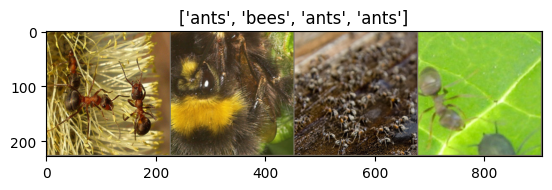

In [11]:
def imshow(inp, title=None):
    """Display image for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

# Get a batch of training data
inputs, classes = next(iter(train_dataloaders))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

### Visualizing the model predictions

Generic function to display predictions for a few images




In [12]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(valid_dataloaders):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

## Finetuning the ConvNet

Load a pretrained model and reset final fully connected layer.




In [13]:
model_ft = models.resnet18(weights='IMAGENET1K_V1')
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to ``nn.Linear(num_ftrs, len(class_names))``.
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 157MB/s]


### Train and evaluate

It should take around 15-25 min on CPU. On GPU though, it takes less than a
minute.




## 과제 4:train function과 validation function을 만들고 학습시 각 epoch마다 learning rate를 확인하세요.

In [14]:
model = model_ft
optimizer = optimizer_ft
scheduler = exp_lr_scheduler
num_epochs = 25

since = time.time()

best_model_wts = copy.deepcopy(model.state_dict())
best_acc = 0.0

for epoch in range(num_epochs):
    print(f'Epoch {epoch}/{num_epochs - 1}')
    print('-' * 10)

    # Each epoch has a training and validation phase
    # <<< Train >>>
    model.train()  # Set model to training mode
    running_loss = 0.0
    running_corrects = 0

    # Iterate over data.
    for inputs, labels in train_dataloaders:
        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward
        # track history if only in train
        with torch.set_grad_enabled(True):
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

            # backward + optimize only if in training phase
            loss.backward()
            optimizer.step()

        # statistics
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
    scheduler.step()

    epoch_loss = running_loss / dataset_sizes['train']
    epoch_acc = running_corrects.double() / dataset_sizes['train']
    print(f'train Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

    # <<< Validation >>>
    model.eval()   # Set model to evaluate mode
    running_loss = 0.0
    running_corrects = 0

    # Iterate over data.
    for inputs, labels in valid_dataloaders:
        inputs = inputs.to(device)
        labels = labels.to(device)

        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

    epoch_loss = running_loss / dataset_sizes['val']
    epoch_acc = running_corrects.double() / dataset_sizes['val']

    print(f'val Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
    # deep copy the model
    if epoch_acc > best_acc:
        best_acc = epoch_acc
        best_model_wts = copy.deepcopy(model.state_dict())

time_elapsed = time.time() - since
print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
print(f'Best val Acc: {best_acc:4f}')

# load best model weights
model.load_state_dict(best_model_wts)
model_ft = model

Epoch 0/24
----------
train Loss: 0.5610 Acc: 0.7143
val Loss: 0.1963 Acc: 0.9216
Epoch 1/24
----------
train Loss: 0.4742 Acc: 0.8122
val Loss: 1.0049 Acc: 0.6797
Epoch 2/24
----------
train Loss: 0.3997 Acc: 0.8449
val Loss: 0.3581 Acc: 0.8431
Epoch 3/24
----------
train Loss: 0.4583 Acc: 0.8000
val Loss: 0.3343 Acc: 0.8693
Epoch 4/24
----------
train Loss: 0.3857 Acc: 0.8408
val Loss: 0.4047 Acc: 0.8301
Epoch 5/24
----------
train Loss: 0.6041 Acc: 0.7714
val Loss: 0.4472 Acc: 0.8366
Epoch 6/24
----------
train Loss: 0.4314 Acc: 0.8204
val Loss: 0.2062 Acc: 0.9216
Epoch 7/24
----------
train Loss: 0.2700 Acc: 0.8816
val Loss: 0.2216 Acc: 0.8954
Epoch 8/24
----------
train Loss: 0.2332 Acc: 0.8980
val Loss: 0.1713 Acc: 0.9150
Epoch 9/24
----------
train Loss: 0.3073 Acc: 0.8694
val Loss: 0.1704 Acc: 0.9281
Epoch 10/24
----------
train Loss: 0.3268 Acc: 0.8531
val Loss: 0.1810 Acc: 0.9281
Epoch 11/24
----------
train Loss: 0.2278 Acc: 0.9020
val Loss: 0.2442 Acc: 0.8889
Epoch 12/24
--

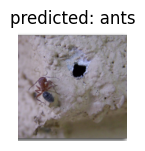

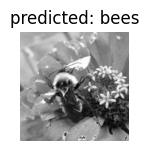

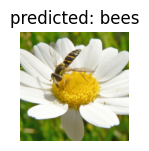

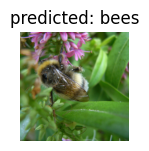

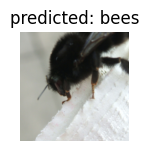

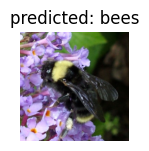

In [15]:
visualize_model(model_ft)

In [16]:
def train(model, criterion, optimizer, scheduler, num_epochs=10):
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
                dataloader = train_dataloaders
            else:
                model.eval()   # Set model to evaluate mode
                dataloader = valid_dataloaders

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data
            for inputs, labels in dataloader:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Zero the parameter gradients
                optimizer.zero_grad()

                # Forward pass
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # Backward pass and optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                        scheduler.step()

                # Statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # Deep copy the model if it's the best so far
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    print(f'Best val Acc: {best_acc:.4f}')

    # Load best model weights
    model.load_state_dict(best_model_wts)
    return model

# Load pretrained ResNet18 model
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 2)
model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

# Train the model
model_ft = train(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=10)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/10
----------
train Loss: 0.6685 Acc: 0.5714
val Loss: 0.6471 Acc: 0.6078

Epoch 2/10
----------
train Loss: 0.6630 Acc: 0.6122
val Loss: 0.6496 Acc: 0.6078

Epoch 3/10
----------
train Loss: 0.6518 Acc: 0.6082
val Loss: 0.6375 Acc: 0.6209

Epoch 4/10
----------
train Loss: 0.6580 Acc: 0.6245
val Loss: 0.6531 Acc: 0.5948

Epoch 5/10
----------
train Loss: 0.6614 Acc: 0.5878
val Loss: 0.6447 Acc: 0.6144

Epoch 6/10
----------
train Loss: 0.6268 Acc: 0.6245
val Loss: 0.6382 Acc: 0.6078

Epoch 7/10
----------
train Loss: 0.6460 Acc: 0.6286
val Loss: 0.6485 Acc: 0.6209

Epoch 8/10
----------
train Loss: 0.6492 Acc: 0.6163
val Loss: 0.6686 Acc: 0.5948

Epoch 9/10
----------
train Loss: 0.6587 Acc: 0.6041
val Loss: 0.6450 Acc: 0.6013

Epoch 10/10
----------
train Loss: 0.6571 Acc: 0.5714
val Loss: 0.6472 Acc: 0.6078

Best val Acc: 0.6209


## ConvNet as fixed feature extractor

Here, we need to freeze all the network except the final layer. We need
to set ``requires_grad = False`` to freeze the parameters so that the
gradients are not computed in ``backward()``.

You can read more about this in the documentation
[here](https://pytorch.org/docs/notes/autograd.html#excluding-subgraphs-from-backward)_.




In [17]:
model_conv = torchvision.models.resnet18(weights='IMAGENET1K_V1')
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

### Train and evaluate

On CPU this will take about half the time compared to previous scenario.
This is expected as gradients don't need to be computed for most of the
network. However, forward does need to be computed.




In [18]:
model = model_conv
scheduler = exp_lr_scheduler
optimizer = optimizer_conv
num_epochs = 25

since = time.time()

best_model_wts = copy.deepcopy(model.state_dict())
best_acc = 0.0

for epoch in range(num_epochs):
    print(f'Epoch {epoch}/{num_epochs - 1}')
    print('-' * 10)

    # Each epoch has a training and validation phase
    # <<< Train >>>
    model.train()  # Set model to training mode
    running_loss = 0.0
    running_corrects = 0

    # Iterate over data.
    for inputs, labels in train_dataloaders:
        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward
        # track history if only in train
        with torch.set_grad_enabled(True):
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

            # backward + optimize only if in training phase
            loss.backward()
            optimizer.step()

        # statistics
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

    epoch_loss = running_loss / dataset_sizes['train']
    epoch_acc = running_corrects.double() / dataset_sizes['train']
    print(f'train Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
    scheduler.step()

    # <<< Validation >>>
    model.eval()   # Set model to evaluate mode
    running_loss = 0.0
    running_corrects = 0

    # Iterate over data.
    for inputs, labels in valid_dataloaders:
        inputs = inputs.to(device)
        labels = labels.to(device)

        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

    epoch_loss = running_loss / dataset_sizes['val']
    epoch_acc = running_corrects.double() / dataset_sizes['val']

    print(f'val Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
    # deep copy the model
    if epoch_acc > best_acc:
        best_acc = epoch_acc
        best_model_wts = copy.deepcopy(model.state_dict())

time_elapsed = time.time() - since
print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
print(f'Best val Acc: {best_acc:4f}')

# load best model weights
model.load_state_dict(best_model_wts)


Epoch 0/24
----------
train Loss: 0.7178 Acc: 0.5918
val Loss: 0.2624 Acc: 0.8954
Epoch 1/24
----------
train Loss: 0.5085 Acc: 0.7714
val Loss: 0.2053 Acc: 0.9281
Epoch 2/24
----------
train Loss: 0.3909 Acc: 0.8163
val Loss: 0.2367 Acc: 0.9150
Epoch 3/24
----------
train Loss: 0.3323 Acc: 0.8327
val Loss: 0.1688 Acc: 0.9477
Epoch 4/24
----------
train Loss: 0.4968 Acc: 0.7551
val Loss: 0.1749 Acc: 0.9412
Epoch 5/24
----------
train Loss: 0.2981 Acc: 0.8735
val Loss: 0.1951 Acc: 0.9150
Epoch 6/24
----------
train Loss: 0.4606 Acc: 0.7918
val Loss: 0.3247 Acc: 0.8758
Epoch 7/24
----------
train Loss: 0.3779 Acc: 0.8163
val Loss: 0.1739 Acc: 0.9477
Epoch 8/24
----------
train Loss: 0.4457 Acc: 0.7918
val Loss: 0.1988 Acc: 0.9346
Epoch 9/24
----------
train Loss: 0.2619 Acc: 0.8939
val Loss: 0.1917 Acc: 0.9477
Epoch 10/24
----------
train Loss: 0.3380 Acc: 0.8653
val Loss: 0.1857 Acc: 0.9477
Epoch 11/24
----------
train Loss: 0.3494 Acc: 0.8653
val Loss: 0.1882 Acc: 0.9477
Epoch 12/24
--

<All keys matched successfully>

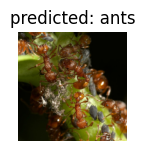

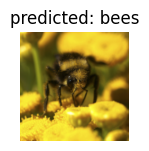

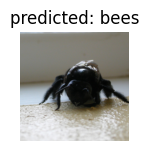

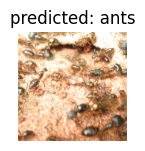

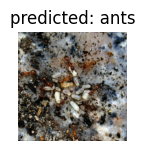

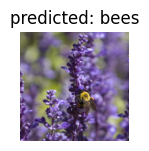

In [19]:
visualize_model(model_conv)

plt.ioff()
plt.show()

## (과제 3: datasets.ImageFolder 대신 Dataset Class를 작성해서 학습)

## 과제 5: Resnet18 model의 하위 모듈을 list로 저장하세요.

Hint: Refer [named_children](https://pytorch.org/docs/stable/generated/torch.nn.Module.html#torch.nn.Module.named_children)

In [20]:
model = torchvision.models.resnet18(weights='IMAGENET1K_V1')

modules = list(model.children())
# for ...
modules

[Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False),
 BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
 ReLU(inplace=True),
 MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False),
 Sequential(
   (0): BasicBlock(
     (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (relu): ReLU(inplace=True)
     (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   )
   (1): BasicBlock(
     (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (relu): ReLU(inplace=True)
     (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), pad

## 과제 6: 각 레이어별로 파라미터가 requires_grad=True인지 False인지 확인하세요.

참고로 relu와 maxpool은 parameter가 존재하지 않음.

In [21]:
# for ...
#   for p in module.parameters():
#     print(name, p.requires_grad)
#     break


#model = models.resnet18(pretrained=True)

for name, module in model.named_children():
    if name in ['relu', 'maxpool']:
        continue
    for p in module.parameters():
        print(name, p.requires_grad)
        break

conv1 True
bn1 True
layer1 True
layer2 True
layer3 True
layer4 True
fc True


## Further Learning for Quantization

If you would like to learn more about the applications of transfer learning,
checkout our [Quantized Transfer Learning for Computer Vision Tutorial](https://pytorch.org/tutorials/intermediate/quantized_transfer_learning_tutorial.html).





## 과제7: container를 이용하여 conv1 부터 layer4까지 구성된 feature extractor를 만드세요.

In [22]:
import torch.nn as nn
import torchvision.models as models

class FeatureExtractor(nn.Module):
    def __init__(self):
        super(FeatureExtractor, self).__init__()

        resnet = models.resnet18(pretrained=True)
        self.conv1 = resnet.conv1
        self.bn1 = resnet.bn1
        self.relu = resnet.relu
        self.layer1 = resnet.layer1
        self.layer2 = resnet.layer2
        self.layer3 = resnet.layer3
        self.layer4 = resnet.layer4
        self.maxpool = resnet.maxpool
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.maxpool(x)
        return x

# Create the feature extractor
feature_extractor = FeatureExtractor()

# Test the feature extractor
input_tensor = torch.randn(1, 3, 224, 224)
output_tensor = feature_extractor(input_tensor)
print(output_tensor.shape)


torch.Size([1, 512, 7, 7])


## 과제 8: ResNet18에 (2,3,224,224) 크기의 입력을 넣었을 때 각 하위 레이어별 출력값의 shape를 확인하세요.

참고: [pytorch resnet18](https://pytorch.org/vision/main/_modules/torchvision/models/resnet.html#resnet18), [pytorch torch.flatten](https://pytorch.org/docs/stable/generated/torch.flatten.html)

In [23]:
# Create ResNet18 model
model = models.resnet18(pretrained=True)

# Define the input tensor
input_tensor = torch.randn(2, 3, 224, 224)

# Pass the input tensor through each layer (except the last linear layer) and print the output shape
for name, module in model.named_children():
    if not isinstance(module, nn.Linear):
        input_tensor = module(input_tensor)
        print(f"{name}: {input_tensor.shape}")

conv1: torch.Size([2, 64, 112, 112])
bn1: torch.Size([2, 64, 112, 112])
relu: torch.Size([2, 64, 112, 112])
maxpool: torch.Size([2, 64, 56, 56])
layer1: torch.Size([2, 64, 56, 56])
layer2: torch.Size([2, 128, 28, 28])
layer3: torch.Size([2, 256, 14, 14])
layer4: torch.Size([2, 512, 7, 7])
avgpool: torch.Size([2, 512, 1, 1])


In [24]:
x = torch.randn(2,3,224,224).to(device)
# for ...
#   ...
#   print(name, x.shape)
#   if ...
#     ...
#     print('flatten', x.shape)

## 과제 9: nn.Module Class를 이용하여 기존 ResNet18에서 Layer4까지만 새로운 avgpool, fc로 추가하여 ResNet18을 재구성하세요.

참고: [pytorch resnet18](https://pytorch.org/vision/main/_modules/torchvision/models/resnet.html#resnet18)

In [25]:
class MyModel(nn.Module):
    def __init__(self, modules):
        super(MyModel, self).__init__()
        self.module_list = nn.ModuleList(modules)

    def forward(self, x):
        for module in self.module_list:
            x = module(x)
        return x

# Create ResNet18 model
model = models.resnet18(pretrained=True)

# Extract the desired modules
modules = [
    model.conv1,
    model.bn1,
    model.relu,
    model.maxpool,
    model.layer1,
    model.layer2,
    model.layer3,
    model.layer4
]

# Create MyModel instance
mymodel = MyModel(modules)

# Test the custom model
input_tensor = torch.randn(2, 3, 224, 224)
output_tensor = mymodel(input_tensor)
print(output_tensor.shape)



torch.Size([2, 512, 7, 7])


## 과제10: ResNet18의 layer 1 ~ layer 3 까지만 고정하고 나머지 layer 4 와 fc는 학습가능하게 하여 학습시키세요.

In [27]:
layer_sel = ['conv1', 'bn1', 'relu', 'maxpool', 'layer1', 'layer2', 'layer3']

# for name, module in mymodel.named_children():
#   if name in layer_sel:
#     print(name, ' fixed layer')
#     for param in module.parameters():
#       ...
#   else:
#     print(name, ' learnable layer')
#     for param in module.parameters():
#       ...

In [26]:
for name, module in mymodel.named_children():
  for p in module.parameters():
    print(name, p.requires_grad)
    break

module_list True


In [28]:
for name, module in mymodel.named_children():
  for p in module.parameters():
    print(name, p.requires_grad)
    break

module_list True


In [33]:
mymodel = mymodel.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
myoptimizer = optim.SGD(mymodel.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(myoptimizer, step_size=7, gamma=0.1)

In [31]:
from torchvision.models import resnet18

# Create ResNet18 model
model = resnet18(pretrained=True)

# Fix layers 1 to 3 and make layers 4 and fc learnable
for name, param in model.named_parameters():
    if 'layer4' in name or 'fc' in name:
        param.requires_grad = True
    else:
        param.requires_grad = False

# Move the model to the desired device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Print the requires_grad status of each parameter
for name, param in model.named_parameters():
    print(name, param.requires_grad)

# Define criterion, optimizer, and scheduler
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

# Example of training loop
for epoch in range(num_epochs):
    # Training code
    model.train()
    for inputs, labels in train_dataloader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

    # Validation code
    model.eval()
    for inputs, labels in valid_dataloader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        with torch.no_grad():
            outputs = model(inputs)
            # Calculate validation loss or metrics
        
    # Update learning rate
    scheduler.step()


conv1.weight False
bn1.weight False
bn1.bias False
layer1.0.conv1.weight False
layer1.0.bn1.weight False
layer1.0.bn1.bias False
layer1.0.conv2.weight False
layer1.0.bn2.weight False
layer1.0.bn2.bias False
layer1.1.conv1.weight False
layer1.1.bn1.weight False
layer1.1.bn1.bias False
layer1.1.conv2.weight False
layer1.1.bn2.weight False
layer1.1.bn2.bias False
layer2.0.conv1.weight False
layer2.0.bn1.weight False
layer2.0.bn1.bias False
layer2.0.conv2.weight False
layer2.0.bn2.weight False
layer2.0.bn2.bias False
layer2.0.downsample.0.weight False
layer2.0.downsample.1.weight False
layer2.0.downsample.1.bias False
layer2.1.conv1.weight False
layer2.1.bn1.weight False
layer2.1.bn1.bias False
layer2.1.conv2.weight False
layer2.1.bn2.weight False
layer2.1.bn2.bias False
layer3.0.conv1.weight False
layer3.0.bn1.weight False
layer3.0.bn1.bias False
layer3.0.conv2.weight False
layer3.0.bn2.weight False
layer3.0.bn2.bias False
layer3.0.downsample.0.weight False
layer3.0.downsample.1.weight Fa